import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import sys
import urllib3
import json
import operator
import collections

import CPTAC.Endometrial as CPTAC

## Edit the following to configure the notebook

In [2]:
'''Edit Below'''

gene = "ARID1A" #The gene you want to examine

number_of_interacting_proteins_to_examine = 30 #The number of interacting proteins you want to look at

search_all_proteins = True #Whether you want to look at effects of gene mutation on ALL proteins

show_hotspot = True #(True or False) Whether you want to examine the effect of hotspot mutations in this gene

show_proteomics = True #(True or False) Whether you want to see results of proteomic data

show_phosphoproteomics  = True #(True or False) Whether you want to see results of phosphoproteomic data

show_transcriptomics = True #(True or False) Whether you want to see results of transcriptomic data

show_subtype = True #(True or False) Whether you want to examine impact of subtype

dataset = 'Endometrial' #options are Endometrial, Ovarian, etc.

## Get the dataframes

In [3]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

## General gene statistics

In [4]:
'''Get the hotspot3D output '''
hotspot_data = pd.ExcelFile('../HotSpot3D_Output/HotSpot3DOutput.xlsx')

'''Get the sheet name called Clusters to find the protein hotspot'''
clusters = hotspot_data.parse('Clusters')


try:
    '''Check if the gene of interest has a hotspot'''
    hotspot_areas = clusters.loc[clusters['Gene/Drug'] == gene]
    hotspot_mutations = hotspot_areas['Mutation/Gene']
    hotspot_mutations = hotspot_mutations.tolist()

    '''A list of mutations present in the hotspot according to our Hotspot3D output'''
    mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
    hotspot_patients = mutated_hotspot['Clinical_Patient_Key']
    print('Patients with hotspot mutations: \n')
    print(hotspot_patients)
    
except:
    print('{}' '{}'.format(gene, ' does not have a hotspot in our data.'))
    hotspot = False

Patients with hotspot mutations: 

Series([], Name: Clinical_Patient_Key, dtype: object)


## Mutation frequency

Total number of patients with ARID1A mutations: 43
Total number of ARID1A mutation instances: 65

                   Mutation Count
Frame_Shift_Del                23
Nonsense_Mutation              17
Missense_Mutation              13
Frame_Shift_Ins                11
In_Frame_Del                    1


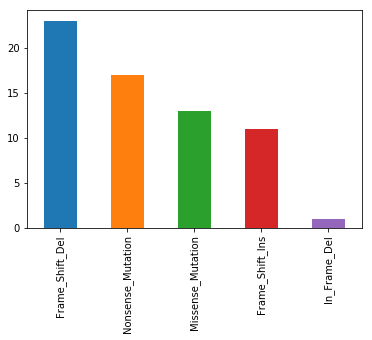

In [5]:
gene_mutated = somatic.loc[somatic['Gene'] == gene]

'''Select from the dataframe all patients with a Mutation in the gene'''
genedf = CPTAC.compare_mutations(proteomics, gene, gene)
mutdf = genedf.loc[genedf['Sample_Status'] == 'Tumor']
mutdf = mutdf.loc[genedf[gene+"_Mutation"] != 'Wildtype_Tumor']

'''See how many patients have a mutation in the given gene'''
num_mutated = len(mutdf)

print('{}' '{}' '{}' '{}' .format('Total number of patients with ' , gene, ' mutations: ', num_mutated))
total_mutations = len(gene_mutated)
print('{}' '{}' '{}' '{}' '{}'.format('Total number of ' , gene, ' mutation instances: ', total_mutations, '\n'))

'''Count the number of instances of various mutation types in the column 'Mutation' in the gene_mutated dataframe.'''

mut_counts = gene_mutated['Mutation'].value_counts()

'''The previous function returns a series. Convert the series to a dataframe'''
counts_df = mut_counts.to_frame()

'''Rename the column to clarify the number of mutations'''
counts_df = counts_df.rename(index=str, columns = { 'Mutation' : 'Mutation Count'})
print(counts_df)

'''Plot the frequencies'''
mut_counts.plot.bar()
plt.show()

## Cis effect of mutation on protein abundance

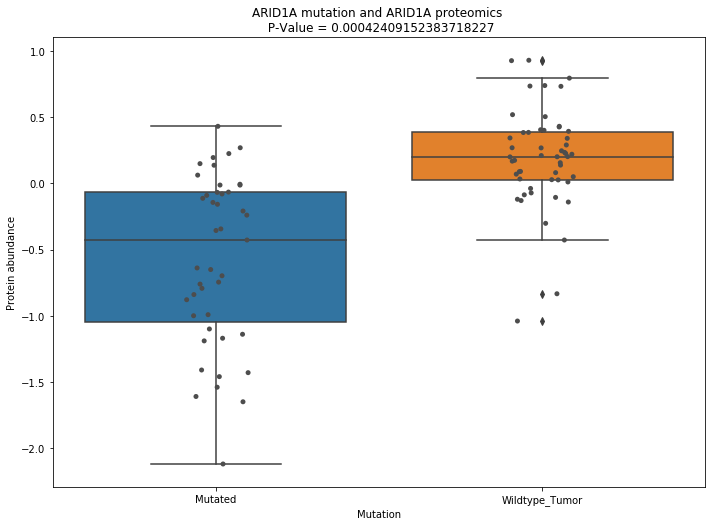

In [6]:
'''Use CPTAC compare mutations to compare'''
cis_df = CPTAC.compare_mutations(proteomics, gene, gene)
cis_df = cis_df.loc[cis_df['Sample_Status'] == 'Tumor']
mutated_df = cis_df.loc[cis_df[gene+'_Mutation'] != 'Wildytpe_Tumor']
wildtype_df = cis_df.loc[cis_df[gene+'_Mutation'] == 'Wildtype_Tumor']
ttest, p_val = scipy.stats.ttest_ind(mutated_df[gene+'_omics'], wildtype_df[gene+'_omics'])

'''Classify all mutations as "mutated" for the plot'''
for i, row in cis_df.iterrows():
    if row[gene + '_Mutation'] != 'Wildtype_Tumor':
        cis_df.at[i,gene+'_Mutation'] = 'Mutated'

'''Generate the plot'''
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
phos_boxplot = sns.boxplot(data=cis_df, x=gene+"_Mutation",y=gene+"_omics")
phos_boxplot.set_title(gene + " mutation and " + gene + " proteomics \n P-Value = " + str(p_val))
phos_boxplot = sns.stripplot(data=cis_df, x=gene+"_Mutation", y=gene+"_omics",jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Protein abundance")
plt.show()

## Access STRING database to compile list of interacting proteins

In [7]:
'''Use urllib3 to access the string database api, gather list of interacting proteins'''
urllib3.disable_warnings()
string_api_url = "https://string-db.org/api"
output_format = "json"
method = "network"

'''Use the specified gene and homo sapiens species code'''
my_gene = [gene]
species = "9606"

'''Format the api request to collect the appropriate information'''
request_url = string_api_url + "/" + output_format + "/" + method + "?"
request_url += "identifiers=%s" % "%0d".join(my_gene)
request_url += "&" + "species=" + species
request_url += "&" + "limit=" + str(number_of_interacting_proteins_to_examine)

'''Send a request to the API, print the response status'''
try:
    http = urllib3.PoolManager()
    response = http.request('GET',request_url)
    print("Accessing String database, response status: ", response.status)
except urllib3.HTTPError as err:
    error_message = err.read()
    print(error_message)
    sys.exit()

interacting_proteins = []
if response.status == 200: 
    '''Get the data from the API's response'''
    data = response.data
    y = json.loads(data)

    '''Make a list of the resulting interacting proteins'''
    for entry in y:
        if entry["preferredName_A"] not in interacting_proteins:
            interacting_proteins.append(entry["preferredName_A"])
        if entry["preferredName_B"] not in interacting_proteins:
            interacting_proteins.append(entry["preferredName_B"])

    print("\nTop " + str(number_of_interacting_proteins_to_examine) + " " + gene + " interacting proteins: \n")
    for ip in interacting_proteins:
        print(ip)
else:
    print("\nSpecified gene was not found in String database, double check that you have it correctly!")
    interacting_proteins.append(gene)

Accessing String database, response status:  200

Top 30 ARID1A interacting proteins: 

NR3C1
CCND1
SMARCC1
SUPT16H
CDK4
SMARCD3
CREBBP
SMARCB1
EP300
KAT2B
DNMT3A
SMARCA2
SMARCC2
KMT2D
ARID1A
SMARCE1
PHF10
BAZ1B
ARID1B
NF1
CDC5L
IRF2
SMARCD1
SMARCD2
SMARCA4
ACTL6A
BCL7B
SS18
DPF2
BCL7A
DPF3


## Examine proteomic levels of interacting protiens

In [8]:
'''Use list of interacting proteins as our protein list'''
protein_list = interacting_proteins

p_values = {}
'''Loop through every protein in the list'''
for protein in protein_list:
    if protein in proteomics.columns:
        '''Use CPTAC compare_mutations to compare proteomic levels when gene is mutated'''
        protdf = CPTAC.compare_mutations(proteomics, protein, gene)
        '''Look only at Tumor types'''
        protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
        '''Split into mutated and wildtype dataframes'''
        mutateddf = protdf.loc[protdf[gene+"_Mutation"] != 'Wildtype_Tumor']
        wildtypedf = protdf.loc[protdf[gene+"_Mutation"] == 'Wildtype_Tumor']
        '''Do a t-test to compare the mutated and wildtype groups, see if they show a significant difference'''
        ttest, p_val = scipy.stats.ttest_ind(mutateddf[protein+"_omics"], wildtypedf[protein+"_omics"])
        '''Store protein and p-value in a dictionary, if it is a real value'''
        if not np.isnan(p_val):
            p_values[protein] = p_val
    else:
        print("Gene ", protein, " not found in proteomics data!")
        
'''Display all the interacting proteins and their p-value'''
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in p_values.items()) + "\n}")

{
NR3C1: 0.001571113275252775
SMARCC1: 0.17867308411819643
SUPT16H: 0.8263293912412149
CDK4: 0.24998401600256126
SMARCD3: 0.0028881229928719204
CREBBP: 0.36672049099178106
SMARCB1: 6.885135488619889e-05
EP300: 0.11361911324823042
DNMT3A: 0.1696353075577391
SMARCA2: 0.015908722488902433
SMARCC2: 8.27047328548376e-05
KMT2D: 0.9530260188159873
ARID1A: 1.0250180625304501e-10
SMARCE1: 0.00014980267328352896
PHF10: 0.24142597337540306
BAZ1B: 0.20372139088283078
ARID1B: 0.2933959777880062
NF1: 0.2931305095807433
CDC5L: 0.16721298753807295
IRF2: 0.9528049523869142
SMARCD1: 0.00017449149012151386
SMARCD2: 0.0017325528008018882
SMARCA4: 0.011534265835122267
ACTL6A: 0.0027479350847987695
BCL7B: 0.016370655210333467
SS18: 0.0821990066558892
DPF2: 2.1666091867648467e-07
BCL7A: 0.5592002438288151
}


## Adjust for multiple testing with a Bonferroni correction

In [9]:
alpha = .05
bonferroni_adjusted_cutoff = alpha/len(p_values)
print('Bonferroni Corrected P-Value Cutoff: {0:10.7f}'.format(bonferroni_adjusted_cutoff))

Bonferroni Corrected P-Value Cutoff:  0.0017857


## Determine which interacting proteins' proteomic abundance are significantly different when gene is mutated

In [10]:
'''Store significant and insignificant results in a dictionary'''
significant_interacting_proteins = {}
unsignificant_interacting_proteins = {}

'''Sort into significant or insignificant, based on whether they meet the bonferroni corrected p-value cutoff'''
for key, val in p_values.items():
    if val <= bonferroni_adjusted_cutoff:
        significant_interacting_proteins[key] = val
    else:
        unsignificant_interacting_proteins[key] = val

'''Print dictionaries'''
print("Significant values: ")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in significant_interacting_proteins.items()) + "\n}")

print("\nInsignificant values: ")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in unsignificant_interacting_proteins.items()) + "\n}")

Significant values: 
{
NR3C1: 0.001571113275252775
SMARCB1: 6.885135488619889e-05
SMARCC2: 8.27047328548376e-05
ARID1A: 1.0250180625304501e-10
SMARCE1: 0.00014980267328352896
SMARCD1: 0.00017449149012151386
SMARCD2: 0.0017325528008018882
DPF2: 2.1666091867648467e-07
}

Insignificant values: 
{
SMARCC1: 0.17867308411819643
SUPT16H: 0.8263293912412149
CDK4: 0.24998401600256126
SMARCD3: 0.0028881229928719204
CREBBP: 0.36672049099178106
EP300: 0.11361911324823042
DNMT3A: 0.1696353075577391
SMARCA2: 0.015908722488902433
KMT2D: 0.9530260188159873
PHF10: 0.24142597337540306
BAZ1B: 0.20372139088283078
ARID1B: 0.2933959777880062
NF1: 0.2931305095807433
CDC5L: 0.16721298753807295
IRF2: 0.9528049523869142
SMARCA4: 0.011534265835122267
ACTL6A: 0.0027479350847987695
BCL7B: 0.016370655210333467
SS18: 0.0821990066558892
BCL7A: 0.5592002438288151
}


## Make a plot showing proteomic difference for most significant protein

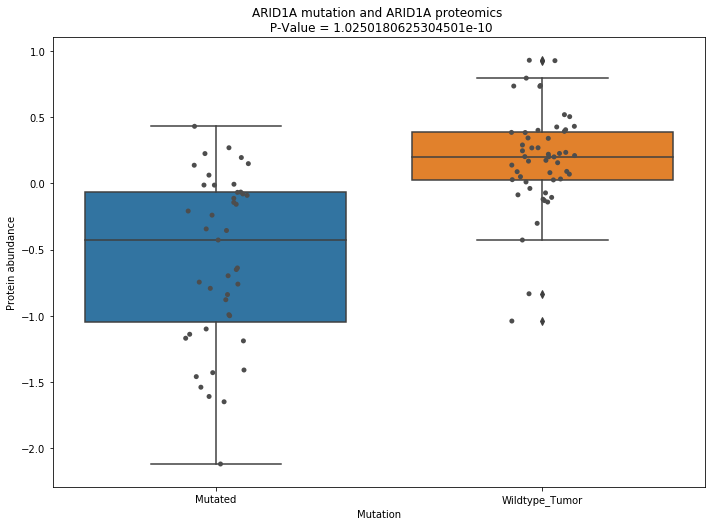

In [11]:
'''Sort p-value dictionary to order most significant p-values first'''
sorted_dict = dict(sorted(p_values.items(), key=lambda x: x[1]))

'''Get the most significant protein'''
most_significant_protein = (next(iter(sorted_dict)))
p_value_of_most_significant = p_values[most_significant_protein]

'''Get dataframe comparing protein abundance with gene mutation'''
most_sig_df = CPTAC.compare_mutations(proteomics, most_significant_protein, gene)

'''Select only tumor type'''
most_sig_df = most_sig_df.loc[most_sig_df['Sample_Status'] == 'Tumor']

'''Classify all mutations as "mutated" for the plot'''
for i, row in most_sig_df.iterrows():
    if row[gene + '_Mutation'] != 'Wildtype_Tumor':
        most_sig_df.at[i,gene+'_Mutation'] = 'Mutated'

'''Generate the plot'''
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
phos_boxplot = sns.boxplot(data=most_sig_df, x=gene+"_Mutation",y=most_significant_protein+"_omics")
phos_boxplot.set_title(gene + " mutation and " + most_significant_protein + " proteomics \n P-Value = " + str(p_value_of_most_significant))
phos_boxplot = sns.stripplot(data=most_sig_df, x=gene+"_Mutation", y=most_significant_protein+"_omics",jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Protein abundance")
plt.show()

## Look at proteomic abundance of all proteins

In [12]:
if search_all_proteins:
    '''Look through every protein in our data'''
    prot_list = proteomics.columns
    p_values = {}
    '''Search through every protein'''
    for prot in prot_list:
        #print(prot)
        '''Use CPTAC compare mutations to look at proteomics of each protein'''
        protdf = CPTAC.compare_mutations(proteomics, prot, gene)
        
        '''Look only at tumor type'''
        protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
        
        '''Split into mutated and wildtype groups'''
        mutateddf = protdf.loc[protdf[gene + "_Mutation"] != 'Wildtype_Tumor'].dropna(axis =0)
        wildtypedf = protdf.loc[protdf[gene+"_Mutation"] == 'Wildtype_Tumor'].dropna(axis=0)
        
        '''Do a ttest to compare the mutated and wildtype groups'''
        ttest, pval = scipy.stats.ttest_ind(mutateddf[prot+"_omics"], wildtypedf[prot+"_omics"])
        
        '''Store results in dictionary'''
        if not np.isnan(pval):
            p_values[prot] = pval

    '''Print results'''
    print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in p_values.items()) + "\n}")

else:
    print("Search all proteins not selected. Change 'search_all_proteins' to True to see analysis")

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{
A1BG: 0.6777767088587238
A2M: 0.24837031755012925
A2ML1: 0.9657499458472719
A4GALT: 0.3278796501165512
AAAS: 0.8327264690261217
AACS: 0.26065383846338674
AADAT: 0.9392804266783878
AAED1: 0.340743898474288
AAGAB: 0.004303852644047509
AAK1: 0.00018821812029614
AAMDC: 0.02516340943646846
AAMP: 0.3584538821312252
AAR2: 0.31610537867327365
AARS: 0.9700452498026758
AARS2: 0.7143108406634218
AARSD1: 0.8042207299733346
AASDHPPT: 0.5576064691679761
AASS: 0.0030876125249391356
AATF: 0.1651848733145091
ABAT: 0.873537732440246
ABCA8: 0.823661769034193
ABCB1: 0.04015145306600341
ABCB10: 0.9653507705523179
ABCB6: 0.4766298466363731
ABCB7: 0.4674691628423385
ABCB8: 0.4111076639385127
ABCC1: 0.147658860385057
ABCC10: 0.5802895817825635
ABCC3: 0.016995827591440346
ABCC4: 0.6033973092546188
ABCD1: 0.1183788237977117
ABCD3: 0.22766918251739943
ABCD4: 0.9681970494706107
ABCE1: 0.8507026745103256
ABCF1: 0.04066321898857129
ABCF2: 0.7019917865983174
ABCF3: 0.12330673877155107
ABCG1: 0.14205789383043158
AB

## Seperate into significant and insignificant proteins

In [13]:
if search_all_proteins:
    '''Adjust for multiple testing with bonferroni correction'''
    bonferroni_adjusted_cutoff = alpha/ len(p_values)
    print('Bonferroni Corrected P-Value Cutoff: {0:10.7f}'.format(bonferroni_adjusted_cutoff))
    
    '''Sort dictionary of proteins and p values'''
    sorted_dict = dict(sorted(p_values.items(), key=lambda x: x[1]))
    
    '''Store significant and insignificant proteins in dictionary'''
    significant_proteins = {}
    insignificant_proteins = {}
    
    '''Look through every protein, determine if is significant by bonferroni adjusted pvalue cutoff'''
    for key, val in sorted_dict.items():
        if val <= bonferroni_adjusted_cutoff:
            significant_proteins[key] = val
        else:
            insignificant_proteins[key] = val
    
    '''Print significant and insignificant proteins'''
    print("Significant proteins: ")
    print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in significant_proteins.items()) + "\n}")

    print("\nInsignificant proteins: ")
    print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in insignificant_proteins.items()) + "\n}")
    
else:
    print("Search all proteins not selected. Change 'search_all_proteins' to True to see analysis")

Bonferroni Corrected P-Value Cutoff:  0.0000046
Significant proteins: 
{
ARID1A: 1.0250180625304501e-10
MAP1S: 1.0101488060908813e-07
DPF2: 2.1666091867648467e-07
KDM4B: 4.414547432570035e-07
RRM1: 4.455869621266498e-07
MAP7D3: 4.880889803877513e-07
CYTH3: 3.1093964024161203e-06
CEP78: 3.7491723386366916e-06
}

Insignificant proteins: 
{
CCDC50: 7.918172051819443e-06
PRRC2B: 8.755042876474208e-06
TNRC6C: 1.3142520657889326e-05
NAA40: 1.3470382747255585e-05
VPS8: 1.475049742364164e-05
NEK7: 1.738573035803121e-05
SNCG: 1.7724390915761372e-05
SENP2: 3.224590245352638e-05
CAPS: 3.597349232192966e-05
C12orf4: 3.822155750854092e-05
TJP3: 3.8288587995268655e-05
TTC19: 3.944218417504093e-05
PNMA1: 4.132441835868658e-05
SEMA4B: 4.1441720388619714e-05
MEF2D: 4.476747541263689e-05
PFKM: 4.853183814180216e-05
GALNT7: 4.9738290161973276e-05
PPP1R21: 5.383461628116499e-05
PPP1R11: 5.468939285636287e-05
UHRF1: 5.814171973033151e-05
CELSR2: 5.9828961907098424e-05
TPD52L2: 6.263619088216422e-05
PCLAF: 

## Plot most significant protein of all proteins

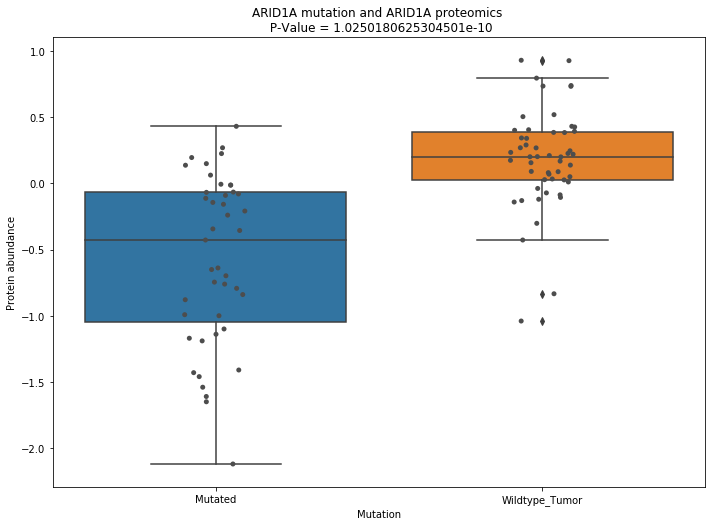

In [14]:
'''Get the most significant protein'''
most_significant_protein = (next(iter(sorted_dict)))
p_value_of_most_significant = sorted_dict[most_significant_protein]

'''Get dataframe comparing protein abundance with gene mutation'''
most_sig_df = CPTAC.compare_mutations(proteomics, most_significant_protein, gene)

'''Select only tumor type'''
most_sig_df = most_sig_df.loc[most_sig_df['Sample_Status'] == 'Tumor']

'''Classify all mutations as "mutated" for the plot'''
for i, row in most_sig_df.iterrows():
    if row[gene + '_Mutation'] != 'Wildtype_Tumor':
        most_sig_df.at[i,gene+'_Mutation'] = 'Mutated'

'''Generate the plot'''
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
phos_boxplot = sns.boxplot(data=most_sig_df, x=gene+"_Mutation",y=most_significant_protein+"_omics")
phos_boxplot.set_title(gene + " mutation and " + most_significant_protein + " proteomics \n P-Value = " + str(p_value_of_most_significant))
phos_boxplot = sns.stripplot(data=most_sig_df, x=gene+"_Mutation", y=most_significant_protein+"_omics",jitter=True, color=".3")
phos_boxplot.set(xlabel="Mutation",ylabel="Protein abundance")
plt.show()

# Phosphoproteomics

## Cis effect of gene mutation on phosphoproteomics

In [15]:
p_values = {}
'''Get dataframe comparing phosphorylation levels in coded protein when gene is mutated'''
phosdf = CPTAC.compare_mutations(phos, gene, gene)
'''Look only at tumor patients'''
phosdf = phosdf.loc[phosdf['Sample_Status'] == 'Tumor']
'''Look through each site in dataframe'''
for site in phosdf.columns:
    '''Check to make sure column we're looking at is a phosphosite'''
    if site != str(gene + "_Mutation") and site is not "Sample_Status":
        '''Split into wildtype and mutated dataframes'''
        mutated_df = phosdf.loc[phosdf[gene+'_Mutation'] != 'Wildtype_Tumor'].dropna(subset=[site])
        wildtype_df = phosdf.loc[phosdf[gene+'_Mutation'] == 'Wildtype_Tumor'].dropna(subset=[site])
        ttest, pval = scipy.stats.ttest_ind(mutated_df[site], wildtype_df[site])
        #print(site, ": ", pval)
        if not np.isnan(pval):
            p_values[site] = pval

print("P-Values of Phosphorylation sites in " + gene + "\n")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in p_values.items()) + "\n}")

P-Values of Phosphorylation sites in ARID1A

{
ARID1A-S1182: 0.005517951244842934
ARID1A-S1184: 4.338935585829806e-07
ARID1A-S1204: 0.14155250204676065
ARID1A-S1320: 0.27704917937119994
ARID1A-S1600: 0.00031034624950776327
ARID1A-S1602: 0.01163528498801577
ARID1A-S1604: 1.5018463694875858e-06
ARID1A-S1751: 0.00018974766882140715
ARID1A-S1755: 7.963746963583787e-10
ARID1A-S1944: 0.875673795335747
ARID1A-S232: 0.5095912087636921
ARID1A-S233: 0.13928066433950942
ARID1A-S301: 0.44272158871729506
ARID1A-S363: 3.402219249324324e-05
ARID1A-S381: 0.294282672395671
ARID1A-S382: 0.6621607802869149
ARID1A-S604: 0.0049440876870870685
ARID1A-S607: 0.013012963842247134
ARID1A-S610: 0.007141616751574528
ARID1A-S696: 0.00018694638006246526
ARID1A-S698: 0.008216898649558919
ARID1A-S702: 0.0005568365894537729
ARID1A-S764: 0.6738864551914017
ARID1A-S769: 0.659584399517888
ARID1A-S772: 0.2568344008841081
ARID1A-S79: 0.04585671031535089
ARID1A-S90: 0.5278588487153884
ARID1A-T1206: 0.02878215553390924
ARID1

### Adjust for multiple testing using a Bonferroni correction
Show statistically significant and insignificant phosphorylation sites

In [16]:
if len(p_values) > 0:
    '''Adjust our alpha by dividing by the number of instances we're testing'''
    bonferroni_adjusted_cutoff = alpha/len(p_values)
    print("Bonferroni Corrected P-Value Cutoff: ", str(round(bonferroni_adjusted_cutoff, 6)))

    significant_sites = {}
    insignificant_sites = {}

    '''Determine whether p-value of each site meets our bonferroni corrected pvalue cutoff'''
    for key, val in p_values.items():
        if val <= bonferroni_adjusted_cutoff:
            significant_sites[key] = val
        else:
            insignificant_sites[key] = val

    '''Print the significant and insignificant sites'''
    print("\nSignificant Phosphorylation Sites: ")
    print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in significant_sites.items()) + "\n}")
    print("\nInsignificant Phosphorylation Sites: ")
    print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in insignificant_sites.items()) + "\n}")
    
else:
    print("Selected protein doesn't have enough phosphorylation data to compare mutated and wildtype phosphorylation levels!")

Bonferroni Corrected P-Value Cutoff:  0.001515

Significant Phosphorylation Sites: 
{
ARID1A-S1184: 4.338935585829806e-07
ARID1A-S1600: 0.00031034624950776327
ARID1A-S1604: 1.5018463694875858e-06
ARID1A-S1751: 0.00018974766882140715
ARID1A-S1755: 7.963746963583787e-10
ARID1A-S363: 3.402219249324324e-05
ARID1A-S696: 0.00018694638006246526
ARID1A-S702: 0.0005568365894537729
}

Insignificant Phosphorylation Sites: 
{
ARID1A-S1182: 0.005517951244842934
ARID1A-S1204: 0.14155250204676065
ARID1A-S1320: 0.27704917937119994
ARID1A-S1602: 0.01163528498801577
ARID1A-S1944: 0.875673795335747
ARID1A-S232: 0.5095912087636921
ARID1A-S233: 0.13928066433950942
ARID1A-S301: 0.44272158871729506
ARID1A-S381: 0.294282672395671
ARID1A-S382: 0.6621607802869149
ARID1A-S604: 0.0049440876870870685
ARID1A-S607: 0.013012963842247134
ARID1A-S610: 0.007141616751574528
ARID1A-S698: 0.008216898649558919
ARID1A-S764: 0.6738864551914017
ARID1A-S769: 0.659584399517888
ARID1A-S772: 0.2568344008841081
ARID1A-S79: 0.045856

### Plot the most significant phosphorylation site in gene

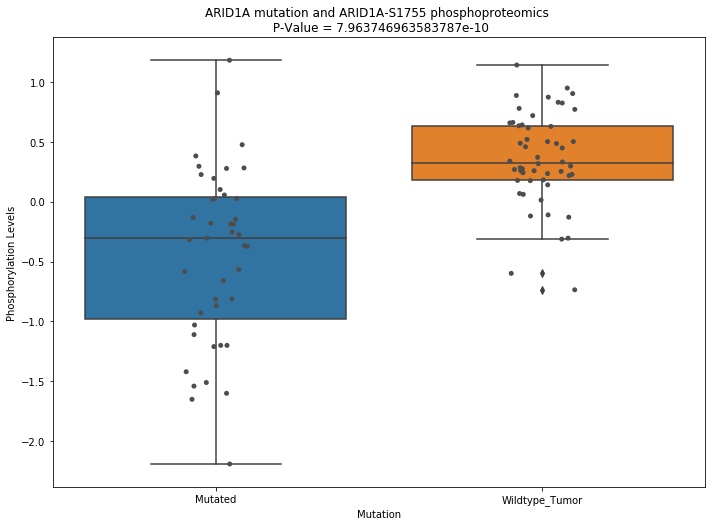

In [17]:
if len(p_values) > 0: 
    '''Sort the dictionary of phosphosites and p-values, putting most significant p-values first'''
    sorted_dict = dict(sorted(p_values.items(), key=lambda x: x[1]))
    most_significant_phos_site = (next(iter(sorted_dict)))
    p_value_of_most_significant = p_values[most_significant_phos_site]

    most_sig_df = CPTAC.compare_mutations(phos, most_significant_phos_site, gene)
    most_sig_df = most_sig_df.loc[most_sig_df['Sample_Status'] == 'Tumor']

    '''Classify all mutations as "mutated" for the plot'''
    for i, row in most_sig_df.iterrows():
        if row[gene + '_Mutation'] != 'Wildtype_Tumor':
            most_sig_df.at[i,gene+'_Mutation'] = 'Mutated'

    '''Generate the plot'''
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize = a4_dims)
    phos_boxplot = sns.boxplot(data=most_sig_df, x=gene+"_Mutation",y=most_significant_phos_site+"_omics")
    phos_boxplot.set_title(gene + " mutation and " + most_significant_phos_site + " phosphoproteomics \n P-Value = " + str(p_value_of_most_significant))
    phos_boxplot = sns.stripplot(data=most_sig_df, x=gene+"_Mutation", y=most_significant_phos_site+"_omics",jitter=True, color=".3")
    phos_boxplot.set(xlabel="Mutation",ylabel="Phosphorylation Levels")
    plt.show()

else:
        print("Selected protein doesn't have enough phosphorylation data to compare mutated and wildtype phosphorylation levels!")

## Phosphorylation of interacting proteins 

In [18]:
'''Look through each protein in interacting protein list'''
p_values = {}
phosdf = CPTAC.compare_mutations(phos, gene, gene)
for protein in interacting_proteins:
    #print(protein)
    try:
        '''Look at phosphorylation data for each site'''
        protdf = CPTAC.compare_mutations(phos, protein, gene).drop(gene+"_Mutation", axis = 1)

        #protdf = protdf.drop(gene+"_Mutation", axis = 1)
        #print(protdf)
        '''Use only tumor types'''
        protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']
        '''Look through each site in dataframe'''
        for site in protdf.columns:
            #print("SITE: ", site)
            if site is not 'Sample_Status':
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf[gene+"_Mutation"] != 'Wildtype_Tumor'].dropna(subset=[site+"_omics"])
                #print(mutateddf)
                wildtypedf = sitedf.loc[sitedf[gene+"_Mutation"] == 'Wildtype_Tumor'].dropna(subset=[site+"_omics"])
                #print("WTDF:", wildtypedf)
                ttest, pval = scipy.stats.ttest_ind(mutateddf[site+"_omics"], wildtypedf[site+"_omics"])
                #print(pval)
                #print(site, ": ", pval)
                if not np.isnan(pval):
                    p_values[site] = pval
            
    except:
        pass
        #print("Exception")
    
    
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in p_values.items()) + "\n}")

Gene CDK4 not found in phosphoproteomics data
Gene SMARCD3 not found in phosphoproteomics data
Gene SMARCB1 not found in phosphoproteomics data
Gene SMARCD1 not found in phosphoproteomics data
{
NR3C1-S111: 0.874557383415268
NR3C1-S113: 0.9403903453228492
NR3C1-S134: 0.1660782141273759
NR3C1-S201: 0.25905239855007844
NR3C1-S203: 0.8201182670612905
NR3C1-S226: 0.9528305497497848
NR3C1-S234: 0.3437465328656893
NR3C1-S241: 0.48008516396776557
NR3C1-S267: 0.5667268925718725
NR3C1-S269: 0.0713045679304968
NR3C1-S305: 0.7210912098691267
NR3C1-S395: 0.09627610975431032
NR3C1-S397: 0.6929935059710193
NR3C1-S410: 0.036878563164690605
NR3C1-S45: 0.3053212692684112
NR3C1-S47: 0.03809088174537794
NR3C1-S509: 0.8506131550725474
NR3C1-T288: 0.6612855120880543
NR3C1-T411: 0.1702006916186135
NR3C1-T414: 0.37071779801504806
NR3C1-T8: 0.4106981377535748
CCND1-T286: 0.4661553382841601
SMARCC1-S310: 5.0996067617865755e-08
SMARCC1-S328: 1.8439344675771823e-07
SMARCC1-S330: 1.1355537527850434e-06
SMARCC1-S3

## Adjust for multiple testing with Bonferroni correction

In [19]:
bonferroni_adjusted_cutoff = alpha/ len(p_values)
print("Bonferroni Corrected P-Value Cutoff: ", bonferroni_adjusted_cutoff)

'''Split into significant and insignificant sites'''
significant_sites = {}
insignificant_sites = {}

sorted_dict = dict(sorted(p_values.items(), key=lambda x: x[1]))
for key, val in sorted_dict.items():
    if val <= bonferroni_adjusted_cutoff:
        significant_sites[key] = val
    else:
        insignificant_sites[key] = val
        
print("\nSignificant Sites: ")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in significant_sites.items()) + "\n}")
print("\nInsignificant Sites: ")
print("{\n" + "\n".join("{}: {}".format(k, v) for k, v in insignificant_sites.items()) + "\n}")

Bonferroni Corrected P-Value Cutoff:  6.321112515802781e-05

Significant Sites: 
{
ARID1A-S1755: 1.9764988463262127e-12
SMARCA4-S1659: 1.1077904370487414e-08
SMARCC2-S283: 3.45298392594057e-08
SMARCC1-S310: 5.0996067617865755e-08
SMARCC1-S328: 1.8439344675771823e-07
SMARCC1-S830: 2.4236379863182413e-07
SMARCA4-S1484: 1.0434373291981024e-06
SMARCC1-S330: 1.1355537527850434e-06
IRF2BP1-S125: 2.2065837466826432e-06
ARID1A-S1604: 4.132221495950146e-06
SMARCA4-S1663: 8.82025375272898e-06
SMARCA4-T1455: 1.0827572369896e-05
IRF2BPL-S334: 1.4255865330888548e-05
RNF113A-S47: 2.277329770699425e-05
SUPT16H-S982: 2.2931679926132772e-05
ARID1A-S696: 3.0226834735208755e-05
ZNF185-T158: 3.484369867997869e-05
SMARCC2-S304: 3.619849984544298e-05
IRF2BP1-S371: 4.3431179666062936e-05
IRF2BPL-S337: 4.8105038030589136e-05
SUPT16H-S986: 5.76547981939953e-05
}

Insignificant Sites: 
{
ZNF185-S155: 6.533612257420954e-05
SMARCA4-S695: 7.160297318630466e-05
ARID1A-S702: 7.659456831802832e-05
RNF113A-S46: 0.0002

## Plot most significant phosphorylation site

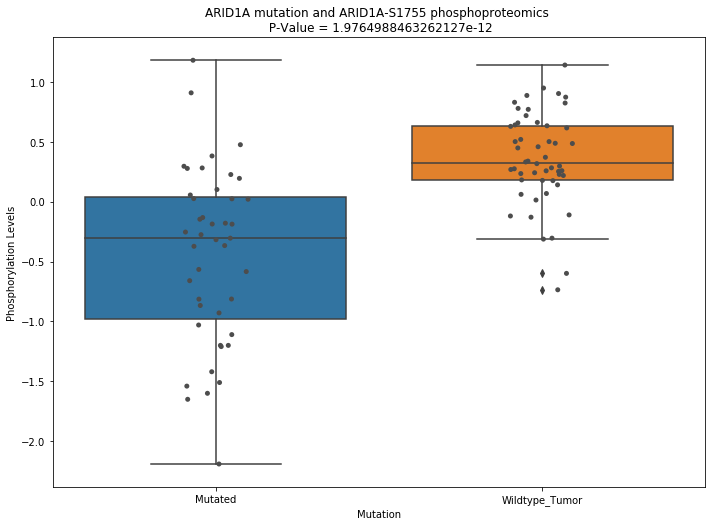

In [20]:
if len(p_values) > 0: 
    '''Sort the dictionary of phosphosites and p-values, putting most significant p-values first'''
    sorted_dict = dict(sorted(p_values.items(), key=lambda x: x[1]))
    most_significant_phos_site = (next(iter(sorted_dict)))
    p_value_of_most_significant = sorted_dict[most_significant_phos_site]

    most_sig_df = CPTAC.compare_mutations(phos, most_significant_phos_site, gene)
    most_sig_df = most_sig_df.loc[most_sig_df['Sample_Status'] == 'Tumor']

    '''Classify all mutations as "mutated" for the plot'''
    for i, row in most_sig_df.iterrows():
        if row[gene + '_Mutation'] != 'Wildtype_Tumor':
            most_sig_df.at[i,gene+'_Mutation'] = 'Mutated'

    '''Generate the plot'''
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize = a4_dims)
    phos_boxplot = sns.boxplot(data=most_sig_df, x=gene+"_Mutation",y=most_significant_phos_site+"_omics")
    phos_boxplot.set_title(gene + " mutation and " + most_significant_phos_site + " phosphoproteomics \n P-Value = " + str(p_value_of_most_significant))
    phos_boxplot = sns.stripplot(data=most_sig_df, x=gene+"_Mutation", y=most_significant_phos_site+"_omics",jitter=True, color=".3")
    phos_boxplot.set(xlabel="Mutation",ylabel="Phosphorylation Levels")
    plt.show()

else:
        print("Selected protein doesn't have enough phosphorylation data to compare mutated and wildtype phosphorylation levels!")